# Example close from PLC-torch paper

In [1]:
import numpy as np
import torch
from torch import nn

import matplotlib.pylab as plt
from pylightcurve_torch import TransitModule

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"selected device: {device}")

selected device: cpu


# Creating datasets
- We simulate transits with varying random parameters 
- we take advantage of pytorch datasets, which simply require overriding their ```__getitem__``` and ```__len__``` method


In [3]:
import torch.distributions as dist
from torch.utils.data import DataLoader


class TransitDataset(torch.utils.data.Dataset):
    def __init__(self, tm, size, seed=0, noise=0., theta={}, phi={}, cache=True):
        """ Creates a Transit Dataset
        
        tm: TransitModule object
        size: size of the dataset (int)
        seed: 
        cache: whether to save in memory the generated samples (bool)
        noise: standard deviation of the gaussian noise injected relative to the stellar flux (float)
        theta: dict of priors (torch.distributions objects) for target params
        phi: dict of priors (torch.distributions objects) for others variables
        """
        self.tm = tm
        self.size = int(size)
        self.seed = int(seed)
        self.cache = cache
        self.noise = float(noise)
        self.theta = theta               
        self.phi = phi                   
        self.priors = theta.copy()
        self.priors.update(phi)
        self.data = dict()

    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        if index in self.data:
            return self.data[index]
        else:
            torch.manual_seed(self.seed + index)
            self.tm.set_params(**{p: prior.sample() for p, prior in self.priors.items()})
            self.data[index] = [self.tm()[0] + torch.randn_like(self.tm.time)[0] * self.noise, 
                                {k: getattr(self.tm, k)[0].detach() for k in self.phi},
                                self.tm.rp_over_rs.detach()[0]]
            return self.data[index]
            
    
def preprocess(x):
    """perform a centering a rescaling of the input"""
    out = (x - 1) * 100
    return out


In [4]:
# Dataset Constants & Params
base_pars = {'e':0.05, 'i':90., 'w': 50., 'rp': 0.05, 'method': 'linear', 'ldc': [0.2], 
             'P': 100., 't0': 5., 'a': 15., 'fp': 0.0001}

# Priors
theta_priors = {'rp': dist.Uniform(0.01, 0.1)}

phi_priors = {'i': dist.Uniform(87.5, 92.5)}

n_pts = 1000
noise = 1e-4

In [5]:
# Transit Model definition 

time_tensor = torch.linspace(0,10, n_pts)
tm = TransitModule(time_tensor, **base_pars, dtype=torch.float64, cache_pos=True)

In [6]:
# Datasets definition

dataset = TransitDataset(tm, 800, theta=theta_priors  , phi=phi_priors, noise=noise)
dataset_val = TransitDataset(tm, 400, seed=len(dataset), theta=theta_priors, phi=phi_priors, noise=noise)
dataset_test = TransitDataset(tm, 500, seed=len(dataset) + len(dataset_val), 
                                 theta=theta_priors, phi=phi_priors, noise=noise)

test_loader = DataLoader(dataset_test, batch_size = len(dataset_test), shuffle=False)
test_batch = next(iter(test_loader))

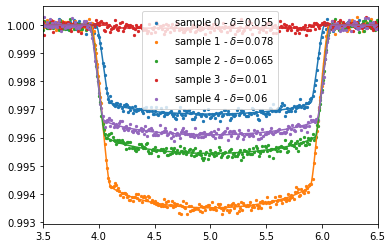

In [7]:
# Quick visu
for i in range(5):
    X, phi, y = dataset[i]
    plt.scatter(time_tensor, X.detach().cpu().T, s= 5, label=f'sample {i} - $\delta$={y.item():.2g}')
    plt.plot(time_tensor, tm(rp=y, **phi).detach().cpu()[0])
    plt.legend()
plt.xlim(3.5,6.5)
plt.show()

In [8]:
X.shape, y.shape, phi['i'].shape

(torch.Size([1000]), torch.Size([1]), torch.Size([1]))

# Defining NN

In [101]:
class SimpleConvNet(nn.Module):
    def __init__(self, input_dim, num_classes, device=None, dropout=0):
        super().__init__()
        self.input_dim = int(input_dim)
        assert self.input_dim > 0
        self.num_classes = int(num_classes)
        assert self.num_classes > 0
        self.dropout = float(dropout)
        assert 0. <= dropout <= 1.
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
           nn.Conv1d(32, 32, kernel_size=5, stride=1, padding=2),
           nn.BatchNorm1d(32),
           nn.ReLU(),
           nn.MaxPool1d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Sequential(nn.Dropout(self.dropout),
                                 nn.Linear(32*(self.input_dim // 2**4), 256), 
                                 nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(256, self.num_classes),
                                 nn.Sigmoid())  
        
    def forward(self, x):
        if len(x.shape) == 2:
            out = x[:,None,:]
        else:
            out = x
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc4(out)
        return out.view(-1, self.num_classes)                                 

In [102]:
# Loss function utility class to record and plot history

from torch.nn.functional import mse_loss
import math

class Criterion:
    def __init__(self, model, lamb=0.5, transit_mask=False):
        self.model = model
        assert 0 <= lamb <= 1
        self.lamb = lamb
        self.transit_mask = transit_mask
        self.loss_history = {}
        self.recons_history = {}
        self.regression_history = {}
        self.best_val = np.inf
        self.best_epoch = 1
        
    def __call__(self, X, phi, y, pred, save_epoch=None):
        """ computes the lambda-regression/reconstruction loss 
        for a batch of:
            - input X, 
            - target y and 
            - predictions pred
        """
        assert not torch.isnan(X).any()
        assert not torch.isnan(pred).any()
        assert not torch.isnan(y).any()
        
        
        loss = 0.
        if math.isclose(self.lamb, 0.):
            regression_loss = torch.tensor([np.nan])
        else:
            regression_loss = mse_loss(pred, y, reduction='mean')
            loss += self.lamb * regression_loss
            
        if math.isclose(self.lamb, 1.):
            recons_loss = torch.tensor([np.nan])
        else:
            recons = self.model(rp=pred, **phi)
            assert not torch.isnan(recons).any()
            if self.transit_mask:
                durations = tm.get_duration(**phi)
                in_transit = torch.abs(time_tensor - tm.mid_time) < durations  / 2
                recons_loss = (mse_loss(recons * in_transit, X * in_transit, reduction='none')
                               / in_transit.sum(-1, keepdim=True)).mean().sqrt()
            else:
                recons_loss = mse_loss(recons, X, reduction='mean') #/ X.shape[-1])
            loss += (1. - self.lamb) * recons_loss

        if save_epoch is not None:
            if save_epoch not in self.loss_history:
                self.loss_history[save_epoch] = []
                self.recons_history[save_epoch] = []
                self.regression_history[save_epoch] = []       
                    
            self.recons_history[save_epoch] += [recons_loss.item()]
            self.regression_history[save_epoch] += [regression_loss.item()]
            self.loss_history[save_epoch] += [loss.item()]
        return loss
    
    def update_best(self, epoch, reduction='mean'):
        current_val = self.get_epoch_loss(epoch, reduction)
        
        if current_val < self.best_val:
            self.best_val = current_val
            self.best_epoch = epoch
    
    def __getitem__(self, epoch):
        return self.get_epoch_loss(epoch)
    
    def get_epoch_loss(self, epoch, reduction='mean'):
        if reduction.lower() == 'mean':
            return np.mean(self.loss_history[epoch])
        elif reduction is None or reduction.lower() == 'none':
            return self.loss_history[epoch]
        elif reduction.lower() == 'sum':
            return np.sum(self.loss_history[epoch])
    
    def plot_history_loss(self, reduction='mean', ma=None, ax=None, scattter=False, **kwargs):
        if ax is None:
            f = plt.figure()
            ax = f.add_subplot()
        if reduction == 'mean':
            losses = np.array(list(self.loss_history.values())).mean(-1)
        else:
            raise NotImplementedError
        if 'label' not in kwargs:
            kwargs['label'] = f'$\lambda$-Loss ($\lambda=${self.lamb})'

        if scatter:
            ax.scatter(list(self.loss_history.keys()), 
                   losses, s = 25,
                   **kwargs)
        else:
            ax.plot(list(self.loss_history.keys()), 
            losses,
            **kwargs)
        if ma:
            ma = int(ma)
            ax.plot(list(self.loss_history.keys()), 
                    pd.Series(losses).rolling(ma, 1).mean(),
                    **kwargs)
        return ax 
    
    def plot_history_recons(self, lambda_scaled=False, reduction='mean', ma=None, 
                            ax=None, scatter=False, **kwargs):
        if ax is None:
            f = plt.figure()
            ax = f.add_subplot()
        if reduction == 'mean':
            losses = np.array(list(self.recons_history.values())).mean(-1)
        else:
            raise NotImplementedError
        if 'label' not in kwargs:
            kwargs['label'] = f'{self.lamb} * ' * lambda_scaled + '$MSE\_reconstruction$'
        if scatter:
            if 's' not in kwargs:
                kwargs['s'] = 25
            ax.scatter(list(self.recons_history.keys()), 
                   losses, 
                   **kwargs)
        else:
            ax.plot(list(self.recons_history.keys()), 
            losses,
            **kwargs)
        if ma:
            ma = int(ma)
            ax.plot(list(self.recons_history.keys()), 
            pd.Series(losses).rolling(ma, 1).mean(),
            **kwargs)
        return ax
    
    def plot_history_regress(self, lambda_scaled=False, reduction='mean', ma=None,
                             ax=None, scatter=False, **kwargs):
        if ax is None:
            f = plt.figure()
            ax = f.add_subplot()
        if reduction == 'mean':
            losses = np.array(list(self.regression_history.values())).mean(-1)
        else:
            raise NotImplementedError

        if 'label' not in kwargs:
            kwargs['label'] = f'{1-self.lamb} * ' * lambda_scaled + '$MSE\_regression$'
        if scatter:
            if 's' not in kwargs:
                kwargs['s'] = 25
            ax.scatter(list(self.regression_history.keys()), 
                   losses, 
                   **kwargs)
        else:
            ax.plot(list(self.regression_history.keys()), 
            losses,
            **kwargs)
        if ma:
            ma = int(ma)
            ax.plot(list(self.regress_history.keys()), 
                    pd.Series(losses).rolling(ma, 1), **kwargs)
        return ax

    def plot_history(self, lambda_scaled=False, reduction='mean', ma=None, ax=None, **kwargs):
        if ax is None:
            f = plt.figure()
            ax = f.add_subplot()
        self.plot_history_loss(reduction, ma, ax, **kwargs)
        self.plot_history_recons(lambda_scaled, reduction, ma, ax, **kwargs)
        self.plot_history_regress(lambda_scaled, reduction, ma, ax, **kwargs)
        ax.set_xlabel('epochs')
        ax.legend()
        ax.set_yscale('log')
        return ax

## Training

In [103]:
def train_net(net, train_dataset, train_criterion, optimizer, epochs=1, start_epoch=None,
              batch_size=100, val_dataset=None, val_criterion=None, freq_eval=10, verbose=True, 
              tune_report=False, stopping_tolerance=1000):
    if len(train_criterion.loss_history):
        last_epoch = np.max(list(train_criterion.loss_history.keys()))
    else:
        last_epoch = 0
        
    if start_epoch is None:
        start_epoch = last_epoch + 1
    else:
        assert start_epoch == last_epoch + 1
 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = None
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        if val_criterion is None:
            print('defaulting val criterion to same as training')
            # By default same criterion as training one
            val_criterion = train_citerion.__class__(train_criterion.tm, train_criterion.alpha)
    losses = []
    val_losses = []
    for epoch in range(start_epoch, start_epoch + epochs):
        # Train one epoch
        epoch_loss = 0.
        for X, phi, y in train_loader:
            net.train()
            optimizer.zero_grad()
            pred = net(preprocess(X)) #.flatten()  
            assert not torch.isnan(X).any()
            assert not torch.isnan(y).any()
            try:
                assert not torch.isnan(pred).any()
            except AssertionError:
                raise AssertionError
            loss = train_criterion(X, phi, y, pred.requires_grad_(), epoch)  # not preprocessed
            loss.backward()
            optimizer.step()
        
        # Validation
        val_loss = None
        if (epoch-1) % freq_eval == 0 and val_dataset is not None:
            net.eval()
            with torch.no_grad():
                for X_val, phi_val, y_val in val_loader:
                    pred = net(preprocess(X_val)) ##.flatten()
                    val_criterion(X_val, phi_val, y_val, pred, epoch).item()
            val_criterion.update_best(epoch)
            if tune_report:
                tune.report(reg_loss=val_criterion.best_val)
            
            val_loss = val_criterion[epoch]
            net.train()
            # Early stopping
            if epoch - val_criterion.best_epoch >= stopping_tolerance:
                if verbose:
                    print('early stopping at epoch', epoch)
                    print('best val loss is', val_criterion.best_val)
                break
            
        if verbose:
            print(f'epoch {epoch} - train_loss = {train_criterion[epoch]}' 
                  + (f' - val_loss = {val_loss}' if val_loss is not None else ''))

In [104]:
batch_size = 100
tol = np.inf
dropout = 0.1
lamb = 0.5

params = [ {'lamb': 1, 'lr': 5e-6, 'batch_size':batch_size, 'stopping_tolerance':tol, 'dropout':dropout},
           {'lamb': lamb, 'lr': 1e-6, 'batch_size':batch_size, 'stopping_tolerance':tol, 'dropout':dropout},
          {'lamb': 0, 'lr': 1e-6, 'batch_size':batch_size, 'stopping_tolerance':tol, 'dropout':dropout},
           ]

#legends = ['$\lambda=1$ (lr={})', f'$\lambda=${lamb}', '$\lambda=0$']

criterion_train = []
criterion_val = []
net = []
optimiser = []
label = []

for i, d in enumerate(params):
    label += [f"$\lambda={d['lamb']}$ (lr={d['lr']})"]
    criterion_train += [Criterion(model=tm, lamb=d['lamb'], transit_mask=True)]
    criterion_val += [Criterion(model=tm, lamb=1, transit_mask=False)]
    net += [SimpleConvNet(n_pts, 1, device='cuda', dropout=d['dropout']).to(device).double()]
    optimiser += [torch.optim.Adam(net[i].parameters(), lr=d['lr'])]
    

In [105]:
epochs = [2] * 3

for i in range(0, len(params)):
    d = params[i]
    train_net(net[i], dataset, epochs = epochs[i], val_dataset = dataset_val,
          batch_size=d['batch_size'],
          optimizer = optimiser[i],   
          train_criterion = criterion_train[i],
          val_criterion = criterion_val[i], 
          freq_eval=5, verbose=True, tune_report=False, stopping_tolerance=d['stopping_tolerance'])


epoch 1 - train_loss = 0.19603647198260674 - val_loss = 0.19711617307375084
epoch 2 - train_loss = 0.16260839071802702
epoch 1 - train_loss = 0.1316530366045138 - val_loss = 0.210639303050911
epoch 2 - train_loss = 0.1274995526553963
epoch 1 - train_loss = 0.005032283868419601 - val_loss = 0.18294593036175064
epoch 2 - train_loss = 0.0048576139492867805


# Classic fit

In [30]:
import scipy
from scipy.optimize import curve_fit

In [34]:
# Fitting RP only

mse = []

for k, (X, phi, y) in enumerate(dataset):
    tm.set_param('i', phi['i'])
    fn = lambda x, rp: tm(rp=rp, phi=phi).numpy().flatten()
    fitted_rp, sigma = curve_fit(fn, xdata=None, ydata=X, p0=[0.1], bounds=(0., 0.2))

    mse.append(((fitted_rp[0] - y.numpy())**2).mean())
    
    if k > 500:
        break
        
print(f"mean MSE = {np.mean(mse):.3g} ; mean RMSE = {np.mean(np.sqrt(mse)):.3g} ; std MSE = {np.std(mse):.3g}")

mean MSE= 1.45e-08 ; mean RMSE= 7.57e-05 ; std MSE=5.02e-08


In [35]:
# fitting Rp and i

mse = []

for k, (X, phi, y) in enumerate(dataset):
#     tm.set_param('i', phi['i'])
    fn = lambda x, rp, phi: tm(rp=rp, phi=phi).numpy().flatten()
    fitted_rp, sigma = curve_fit(fn, xdata=None, ydata=X, p0=[0.1, 90], bounds=[(0., 0.2), (85,90)])

    mse.append(((fitted_rp[0] - y.numpy())**2).mean())
    
    if k > 500:
        break
        
print(f"mean MSE = {np.mean(mse):.3g} ; mean RMSE = {np.mean(np.sqrt(mse)):.3g} ; std MSE = {np.std(mse):.3g}")

mean MSE= 2.41e-06 ; mean RMSE= 0.00123 ; std MSE=3.57e-06
